# 目的

Onスイッチのorthogonality計算.  
OFF (`220908_all_combi` )の時と全く同じ戦略で計算を行う.  

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.spatial import distance
import copy
from multiprocessing import Pool

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


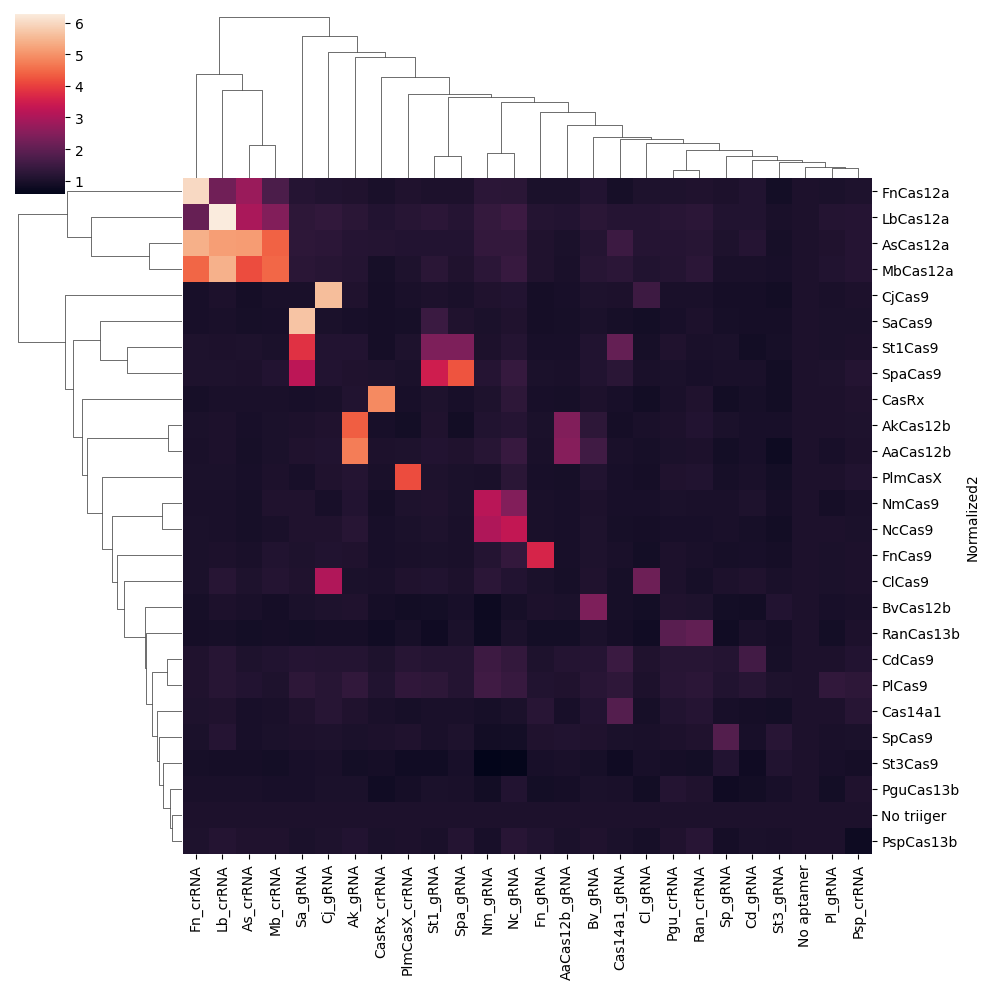

In [14]:
df0 = pd.read_excel("../datasets/Crosstalk-ON_for-sumi.xlsx", index_col = 0, sheet_name=0)
df1 = pd.read_excel("../datasets/Crosstalk-ON_for-sumi.xlsx", index_col = 0, sheet_name=1)
df2 = pd.read_excel("../datasets/Crosstalk-ON_for-sumi.xlsx", index_col = 0, sheet_name=2)
df_raw = (df0 + df1 + df2)/3

sns.clustermap(df_raw)

In [39]:
gdict = {
            "AaCas12b":"AaCas12b_gRNA",
            "AkCas12b":"Ak_gRNA",
            "AsCas12a":"As_crRNA",
            "BvCas12b":"Bv_gRNA",
            "Cas14a1":"Cas14a1_gRNA",
            "CasRx":"CasRx_crRNA",
            "CdCas9":"Cd_gRNA",
            "CjCas9":"Cj_gRNA",
            "ClCas9":"Cl_gRNA",
            "FnCas12a":"Fn_crRNA",
            "FnCas9":"Fn_gRNA",
            "L7Ae":"BoxCD",
            "LbCas12a":"Lb_crRNA",
            "MS2CP(V29I)":"scMS2(WTx2)",
            "MbCas12a":"Mb_crRNA",
            "NcCas9":"Nc_gRNA",
            "NmCas9":"Nm_gRNA",
            "No triiger":"No aptamer",
            "PP7CP":"scPP7(WTx2)",
            "PguCas13b":"Pgu_crRNA",
            "PlCas9":"Pl_gRNA",
            "PlmCasX":"PlmCasX_crRNA",
            "PspCas13b":"Psp_crRNA",
            "RanCas13b":"Ran_crRNA",
            "SaCas9":"Sa_gRNA",
            "SpCas9":"Sp_gRNA",
            "SpaCas9":"Spa_gRNA",
            "St1Cas9":"St1_gRNA",
            "St3Cas9":"St3_gRNA"}

drop_genes       = ["No triiger", "St3Cas9", "PguCas13b", "PspCas13b", "CasRx"]
drop_aptamers = [gdict[p] for p in drop_genes]

necessary_genes = ["SaCas9", "CjCas9"]

df = df_raw.drop(labels = drop_genes,axis= 0).drop(labels = drop_aptamers, axis= 1)
df.head()

,Sp_gRNA,Sa_gRNA,Cj_gRNA,Nm_gRNA,St1_gRNA,Fn_gRNA,Cd_gRNA,Cl_gRNA,Pl_gRNA,Nc_gRNA,...,As_crRNA,Fn_crRNA,Lb_crRNA,Mb_crRNA,Ak_gRNA,Bv_gRNA,Ran_crRNA,PlmCasX_crRNA,Cas14a1_gRNA,AaCas12b_gRNA
Normalized2,,,,,,,,,,,,,,,,,,,,,
SpCas9,1.804307,1.017783,1.036308,0.849275,0.962779,1.047620,0.939252,0.955232,0.965700,0.885326,...,0.939046,0.983155,1.153299,0.979934,0.988375,1.047964,1.054943,1.045387,0.987064,1.081261
SaCas9,0.931671,5.678037,0.998645,0.985268,1.449663,0.907846,0.903523,0.882032,0.990814,1.053165,...,0.924433,0.949681,0.957126,0.951791,0.938839,0.983215,1.012077,0.910024,0.914731,0.911680
CjCas9,0.894951,0.974461,5.607344,1.061550,1.006955,0.905238,0.897507,1.490368,0.964822,1.101074,...,0.888961,0.937092,0.999005,0.963843,1.058241,1.029516,0.970051,0.958412,1.005516,0.933137
NmCas9,0.960144,1.048591,0.937783,3.163867,1.054675,0.970468,1.038188,0.946211,0.895049,2.465477,...,0.920707,0.961438,0.957644,1.048681,1.101581,1.008514,0.967562,1.030743,0.945572,0.943695
St1Cas9,0.986157,3.822979,1.094589,1.017571,2.392926,0.934474,0.855795,0.917770,0.998779,1.117891,...,1.025926,1.027061,1.002532,0.977393,1.093517,1.076203,0.976028,1.025731,2.061775,0.946979


In [40]:
from itertools import combinations
from multiprocessing import Pool, get_context


def calc_min_intradist(p_list):
    state = df[[gdict[gene] for gene in p_list]].loc[p_list]
    # print(state)
    
    def dist(state, pa,pb):
        d = distance.cosine(state.loc[pa], state.loc[pb])
        return d

    min_dist = float("inf")
    for i in range(len(p_list)):
        for j in range(len(p_list)):
            if i > j:
                d = dist(state, p_list[i], p_list[j])
                if d < min_dist:
                    min_dist = d
    return p_list, min_dist


def calc_min_intradist_m1(p_list):
    state = df[[gdict[gene] for gene in p_list]].loc[p_list] - 1
    # print(state)
    
    def dist(state, pa,pb):
        d = distance.cosine(state.loc[pa], state.loc[pb])
        return d

    min_dist = float("inf")
    for i in range(len(p_list)):
        for j in range(len(p_list)):
            if i > j:
                d = dist(state, p_list[i], p_list[j])
                if d < min_dist:
                    min_dist = d
    return p_list, min_dist



calc_min_intradist_m1(necessary_genes)

(['SaCas9', 'CjCas9'], 1.0058328257406959)

In [41]:
def generate_combi(genes, N_PROTEINS):
    genes_candidate = copy.copy(list(genes))
    for ng in necessary_genes:
        genes_candidate.remove(ng)
    return [necessary_genes + list(others) for others in combinations(genes_candidate, N_PROTEINS-len(necessary_genes))]


def get_best(res_dist):
    best_combi = ()
    best_score = 0
    for c, s in res_dist:
        if s > best_score:
            best_combi = c
            best_score = s
    return best_combi, best_score


generate_combi(df.index, 4)[:10]

[['SaCas9', 'CjCas9', 'SpCas9', 'NmCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'St1Cas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'FnCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'CdCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'ClCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'PlCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'NcCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'SpaCas9'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'AsCas12a'],
 ['SaCas9', 'CjCas9', 'SpCas9', 'FnCas12a']]

In [38]:
%%time 

with get_context("fork").Pool(5) as p:
    res_dist = p.map(
        calc_min_intradist,
        generate_combi(df.index.values, 8)
    )

get_best(res_dist)

CPU times: user 75.2 ms, sys: 69.5 ms, total: 145 ms
Wall time: 18.8 s


(['SaCas9',
  'CjCas9',
  'NmCas9',
  'FnCas9',
  'FnCas12a',
  'LbCas12a',
  'AkCas12b',
  'PlmCasX'],
 0.29186725347514075)

In [42]:
log_best_combi = dict()

for N_PROTEINS in range(3, 18):
    with get_context("fork").Pool(5) as p:
        res_dist = p.map(
            calc_min_intradist,
            generate_combi(df.index.values, N_PROTEINS)
        )
        p.close()
        
    log_best_combi[N_PROTEINS] = get_best(res_dist)
    print(N_PROTEINS, get_best(res_dist))

3 (['SaCas9', 'CjCas9', 'FnCas12a'], 0.6340448616625687)
4 (['SaCas9', 'CjCas9', 'FnCas12a', 'PlmCasX'], 0.5542373195468743)
5 (['SaCas9', 'CjCas9', 'AsCas12a', 'AkCas12b', 'PlmCasX'], 0.48197606973832363)
6 (['SaCas9', 'CjCas9', 'FnCas9', 'AsCas12a', 'AkCas12b', 'PlmCasX'], 0.4200087666987582)
7 (['SaCas9', 'CjCas9', 'FnCas9', 'FnCas12a', 'LbCas12a', 'AkCas12b', 'PlmCasX'], 0.32868806089320957)
8 (['SaCas9', 'CjCas9', 'NmCas9', 'FnCas9', 'FnCas12a', 'LbCas12a', 'AkCas12b', 'PlmCasX'], 0.29186725347514075)
9 (['SaCas9', 'CjCas9', 'NmCas9', 'FnCas9', 'FnCas12a', 'LbCas12a', 'AkCas12b', 'BvCas12b', 'PlmCasX'], 0.22881903187440467)
10 (['SaCas9', 'CjCas9', 'NmCas9', 'FnCas9', 'SpaCas9', 'FnCas12a', 'LbCas12a', 'AkCas12b', 'BvCas12b', 'PlmCasX'], 0.2083196043808604)
11 (['SaCas9', 'CjCas9', 'NmCas9', 'FnCas9', 'SpaCas9', 'FnCas12a', 'LbCas12a', 'AkCas12b', 'BvCas12b', 'RanCas13b', 'PlmCasX'], 0.10679809604280288)
12 (['SaCas9', 'CjCas9', 'SpCas9', 'NmCas9', 'FnCas9', 'SpaCas9', 'AsCas12a',

In [43]:
log_best_combi_m1 = dict()

for N_PROTEINS in range(3, 18):
    with get_context("fork").Pool(5) as p:
        res_dist = p.map(
            calc_min_intradist_m1,
            generate_combi(df.index.values, N_PROTEINS)
        )
        p.close()
        
    log_best_combi_m1[N_PROTEINS] = get_best(res_dist)
    print(N_PROTEINS, get_best(res_dist))

3 (['SaCas9', 'CjCas9', 'RanCas13b'], 1.0058494631601649)
4 (['SaCas9', 'CjCas9', 'FnCas9', 'RanCas13b'], 0.9925565060389531)
5 (['SaCas9', 'CjCas9', 'FnCas9', 'RanCas13b', 'PlmCasX'], 0.9918111033947713)
6 (['SaCas9', 'CjCas9', 'FnCas9', 'FnCas12a', 'RanCas13b', 'PlmCasX'], 0.9821627063988836)
7 (['SaCas9', 'CjCas9', 'FnCas9', 'FnCas12a', 'BvCas12b', 'RanCas13b', 'PlmCasX'], 0.9738259570118218)
8 (['SaCas9', 'CjCas9', 'SpCas9', 'FnCas9', 'FnCas12a', 'AkCas12b', 'RanCas13b', 'PlmCasX'], 0.9691733356744047)
9 (['SaCas9', 'CjCas9', 'SpCas9', 'NmCas9', 'FnCas9', 'AsCas12a', 'BvCas12b', 'RanCas13b', 'PlmCasX'], 0.9402457033880318)
10 (['SaCas9', 'CjCas9', 'SpCas9', 'NmCas9', 'FnCas9', 'MbCas12a', 'AkCas12b', 'BvCas12b', 'RanCas13b', 'PlmCasX'], 0.8783473766464467)
11 (['SaCas9', 'CjCas9', 'SpCas9', 'NmCas9', 'FnCas9', 'MbCas12a', 'AkCas12b', 'BvCas12b', 'RanCas13b', 'PlmCasX', 'Cas14a1'], 0.8070428708480236)
12 (['SaCas9', 'CjCas9', 'SpCas9', 'FnCas9', 'NcCas9', 'FnCas12a', 'LbCas12a', 'Bv

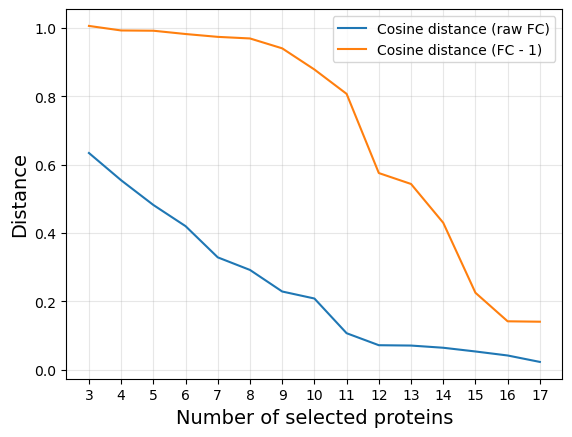

In [45]:
plt.plot(range(3, 18), [dublet[1] for n, dublet in log_best_combi.items()], label = "Cosine distance (raw FC)")
plt.plot(range(3, 18), [dublet[1] for n, dublet in log_best_combi_m1.items()], label = "Cosine distance (FC - 1)")
plt.grid(alpha = 0.3)
plt.xticks(range(3,18))
plt.xlabel("Number of selected proteins", fontsize = 14)
plt.ylabel("Distance", fontsize = 14)
plt.legend()


plt.savefig("../outputs/distance_nmembers_onswitch_v2.pdf", transparent = True, dpi = 300)
plt.savefig("../outputs/distance_nmembers_onswitch_v2.png", transparent = True, dpi = 300)